# Domain adaptation analysis

## Initial settings

#### Dependencies

In [ ]:
%pip install --user -qr ./requirements.txt

#### Import and Utilities

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from torchmetrics import Accuracy
from torchvision import transforms
import torchvision.models as models

import torchmetrics

from matplotlib import pyplot as plt

import os
import numpy as np

import copy

## Dataset Pre Analysis

In [2]:
from scripts.dataset.data_module import CulturalSiteDataModule

dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


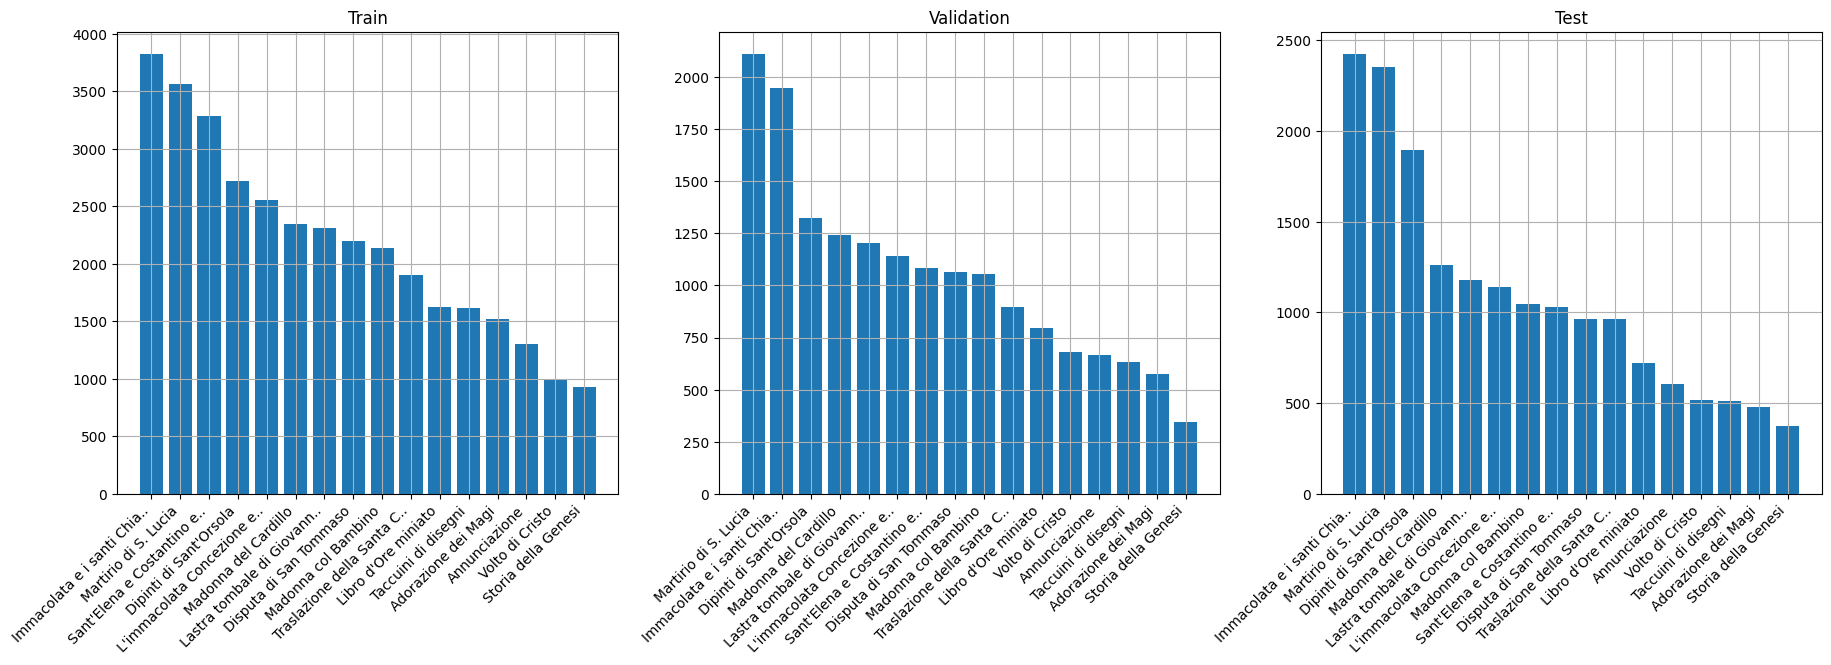

In [4]:
fig, (train_subplot, val_subplot, test_subplot) = plt.subplots(1, 3)
dm.train_preanalysis(train_subplot, 'Train')
dm.val_preanalysis(val_subplot, 'Validation')
dm.test_preanalysis(test_subplot, 'Test')
fig.set_size_inches(22, 6)
plt.show()

## Modelli presi in esame

In [9]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)

        self.pool1 = torch.nn.MaxPool2d(2)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        n_sizes = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.accuracy = Accuracy()

    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x
    
    # will be used during inference
    def forward(self, x):
       x = self._forward_features(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       
       return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    # TODO: da implementare come furnari, permetter un calcolo più preciso dell'accuracy
    # def validation_epoch_end(self, outputs):
    #     #concateniamo tutte le predizioni 
    #     predictions = np.concatenate([o['predictions'] for o in outputs])
    #     #concateniamo tutte le etichette
    #     labels = np.concatenate([o['labels'] for o in outputs])
        
    #     acc = accuracy_score(labels, predictions)
        
    #     self.log('val/accuracy', acc

In [2]:
class ResNet50Model(pl.LightningModule):
    
    def __init__(self, pretrained=False, in_channels = 3, num_classes = 16, lr=1e-3, momentum=0):
        super(ResNet50Model, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr
        self.momentum = momentum
        
        self.model = models.resnet50(pretrained=pretrained)
        
        if pretrained is True:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.Dropout(0.5),
            nn.Linear(512, self.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):        
        x, y = batch        
        preds = self.model(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.model(x)        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('val_loss', loss.item(), on_epoch=True)
        self.log('val_acc', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.model(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test_acc', self.test_acc, on_epoch=True)

    # def validation_epoch_end(self, outputs): #? forse non necessaria, on_epoch=True stampa valori accumulati per epoca
    #     #concateniamo tutte le predizioni 
    #     predictions = np.concatenate([o['predictions'] for o in outputs])
    #     #concateniamo tutte le etichette
    #     labels = np.concatenate([o['labels'] for o in outputs])
        
    #     acc = self.val_acc(labels, predictions)
        
    #     self.log('val/accuracy', self.val_acc)

## Filtering study case

Si è notato che alcune patches estratte dal dataset originale consistono in un insieme di pixel che non rispecchiano a prima vista l'immagine rappresentata. Si vuole dunque porre in analisi i casi di studio per cui:
1) Training effettuato sul dataset non filtrato
2) Training effettuato sul dataset filtrato (rimosse patches con meno di 30 pixel per lato)

Se ne analizzano i risultati ottenuti.

### Caso 1: Training effettuato sul dataset non filtrato

#### Transform pipeline

Calcolo media e deviazione standard per la nomalizzazione:

In [4]:
# Non è necessario rieseguire la cella
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.27882981 0.28949824 0.31447853]
Std: [0.16738273 0.1728493  0.17549583]


In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.27882981, 0.28949824, 0.31447853), std=(0.16738273, 0.1728493, 0.17549583))
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),             # In fase di test, applichiamo una trasformazione simile ma sostituiamo RandomCrop con CenterCrop . Questo in pratica
                                            # serve a far sì che la fase di test sia sempre deterministica.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.27882981, 0.28949824, 0.31447853), (0.16738273, 0.1728493, 0.17549583))
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### Training (no filter)

In [ ]:
#model = LitModel((3, 32, 32), dm.num_classes)
model = ResNet50Model(num_classes=16)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="no_filter_train", version="ResNet_1_lr_1e-3_m_0")

# Initialize Callbacks
# early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.1f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=-1,     # lo stoppi tu manualmente, non ha epoche di riferimento per finire
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     logger=logger,
                     callbacks=[# early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

In [9]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator="gpu")
model = ResNet50Model(num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_1_lr_1e-3_m_0", "checkpoints" , "epoch=14-step=16335-val_loss=0.2.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\no_filter_train\ResNet_1_lr_1e-3_m_0\checkpoints\epoch=14-step=16335-val_loss=0.2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\no_filter_train\ResNet_1_lr_1e-3_m_0\checkpoints\epoch=14-step=16335-val_loss=0.2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9368204474449158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9368204474449158}]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=tb_logs/

### Caso 2: Training effettuato sul dataset filtrato

Si è notato che alcune immagini non rapresetavano pienamente le caratteristiche dell'oggetto da classificare, per cui si è optato di scartare le immaggini con meno di 30px per lato.

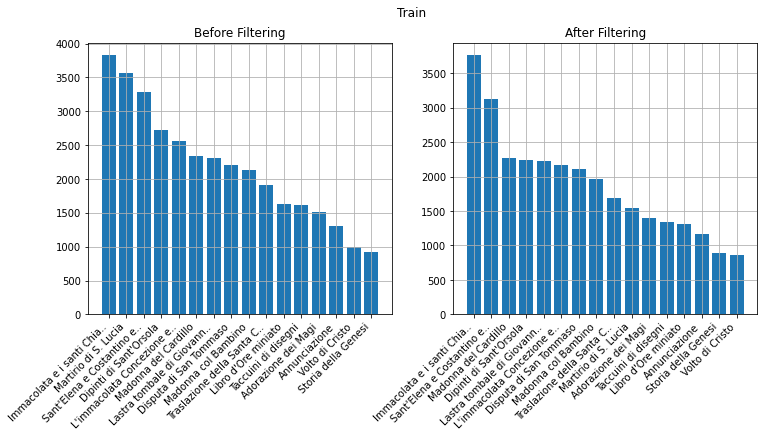

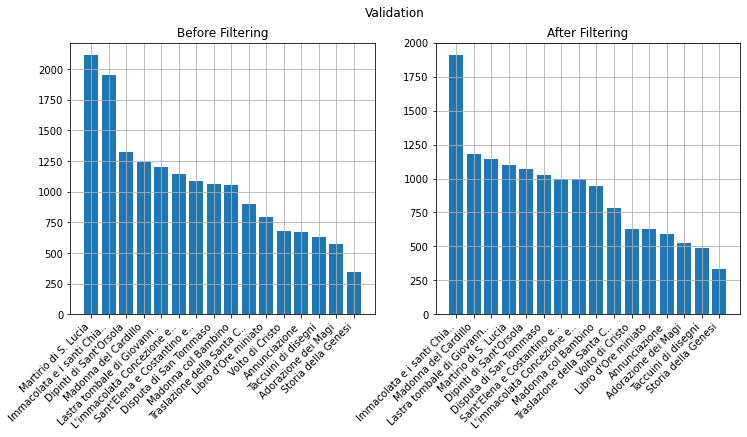

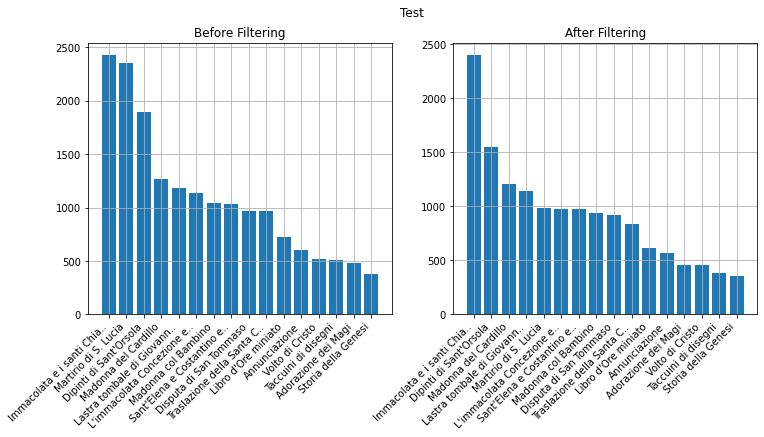

In [10]:
soglia_pixel = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(soglia_pixel)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(soglia_pixel)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(soglia_pixel)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

#### Transform pipeline

Calcolo media e deviazione standard per la nomalizzazione:

In [7]:
# Non è necessario rieseguire questa cella
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


In [11]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),             # In fase di test, applichiamo una trasformazione simile ma sostituiamo RandomCrop con CenterCrop . Questo in pratica
                                            # serve a far sì che la fase di test sia sempre deterministica.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### Training (filtered dataset)

In [ ]:
#model = LitModel((3, 32, 32), dm.num_classes)
model = ResNet50Model(num_classes=16, lr=1e-5)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="filtered_train", version="ResNet_0_lr_1e-5_m_0")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.1f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=25,
                     accelerator="gpu", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     logger=logger,
                     callbacks=[# early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=dm.test_dataloader())

In [12]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator="gpu")
model = ResNet50Model(num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "latest-epoch=24-step=23000.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-3_m_0\checkpoints\latest-epoch=24-step=23000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-3_m_0\checkpoints\latest-epoch=24-step=23000.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9699212312698364
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9699212312698364}]

TODO: mettere considerazioni, ad esempio quale dei due percorsi si è optato, se considerare il dataset filtrato o quello originale per lo studio

Il valore ottimale di learning rate con il modello valutato è 1e-4. Per ora abbiamo constatato che il filtro migliora sia loss che accuracy del validation.

## Domain adaptation study cases

### 1. Baseline approaches without adaption
Il primo caso di studio è quello di allenare il classificatore sul sintetico e poi testarlo nudo e crudo sul reale, valutare le performance.

### Study Cases

#### 1)  the model is trained on synthetic images and tested on synthetic images (no domain shift)

L'allenamento è il medesimo effettuato sopra. Viene preso in esame il caso 2 filtrato in quanto ha restituito risultati migliori.

In [3]:
from scripts.dataset.data_module import CulturalSiteDataModule

print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset appling filter")
soglia_pixel = 30
dm.filter_train(soglia_pixel)
dm.filter_val(soglia_pixel)
dm.filter_test(soglia_pixel)

print("Dataset set transform")
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),             # In fase di test, applichiamo una trasformazione simile ma sostituiamo RandomCrop con CenterCrop . Questo in pratica
                                            # serve a far sì che la fase di test sia sempre deterministica.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)


Dataset setup
Classification dataset found.
Dataset appling filter
Dataset set transform


In [6]:
trainer = pl.Trainer(accelerator="gpu")
model = ResNet50Model(num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\ep

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9799022078514099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9799022078514099}]

####  2) the model is trained on synthetic images and tested on real images (no adaptation)

Dataset setup
Classification dataset found.
Dataset appling filter
Dataset set transform


AttributeError: 'NoneType' object has no attribute 'set_transform'

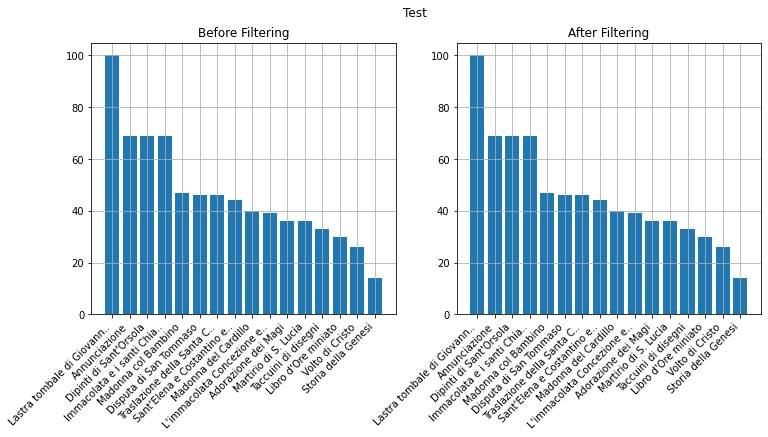

In [10]:
from scripts.dataset.data_module import CulturalSiteDataModule

print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset appling filter")
test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(soglia_pixel=30)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),             # In fase di test, applichiamo una trasformazione simile ma sostituiamo RandomCrop con CenterCrop . Questo in pratica
                                            # serve a far sì che la fase di test sia sempre deterministica.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_test_trasform(val_and_test_transform)
plt.show()

In [9]:
trainer = pl.Trainer(accelerator="gpu")
model = ResNet50Model(num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\ep

Testing: 0it [00:00, ?it/s]

UnboundLocalError: Caught UnboundLocalError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\danil\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\danil\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\danil\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "e:\github\deep-learning-project\scripts\dataset\dataset.py", line 83, in __getitem__
    return transf_img, image_class
UnboundLocalError: local variable 'transf_img' referenced before assignment


 #### 3) the model is trained on real images and tested on real images

In [18]:
dm = CulturalSiteDataModule(batch_size=32, dataset_type=CulturalSiteDataModule.REAL_DATASET, num_classes=16) # todo: istanziare CulturalSiteDataset, preparare i dati
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


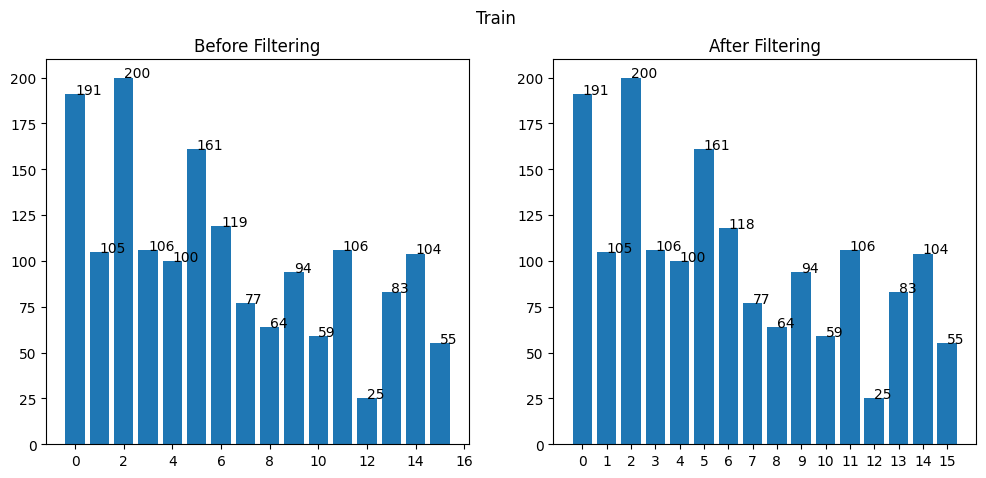

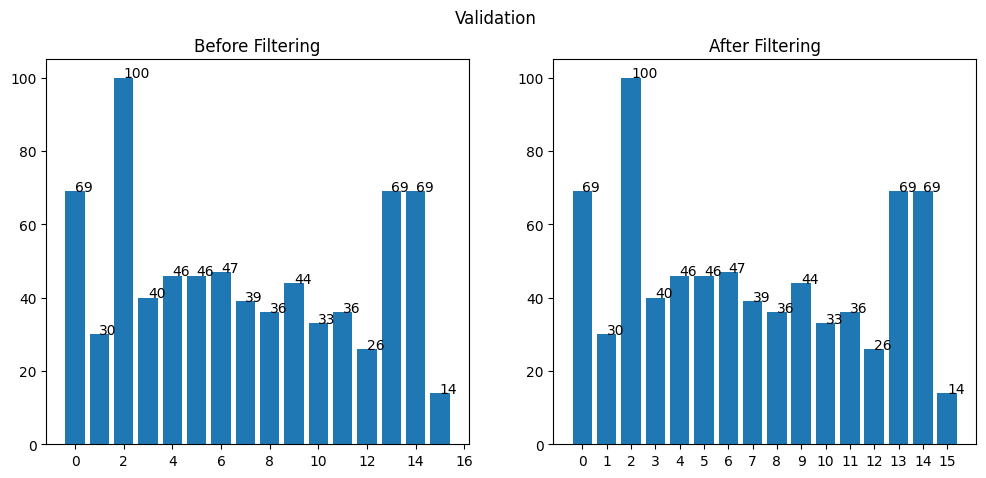

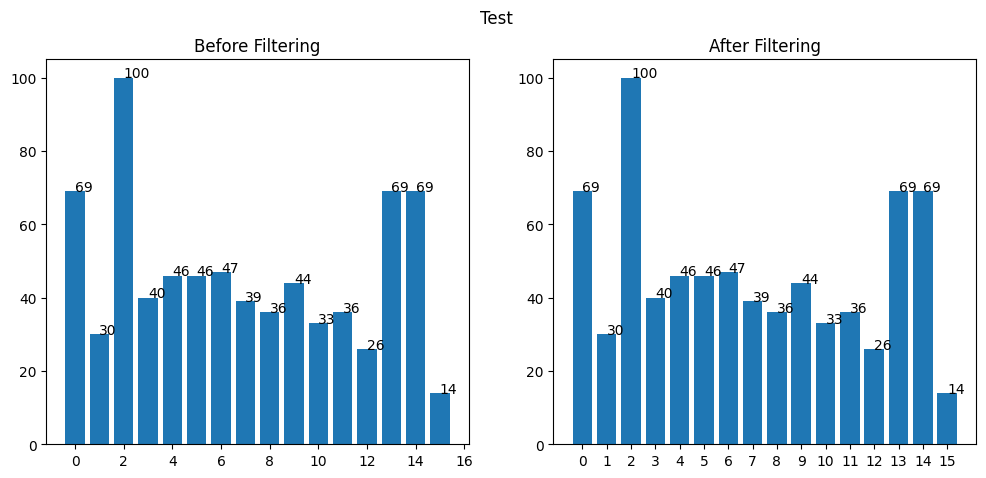

In [19]:
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train()
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val()
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test()
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

plt.show()

In [22]:
model = LitModel((3, 32, 32), dm.num_classes)

# Initialize logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

# Initialize a trainer
# todo: vedere se possibile riconoscere automaticamente il device
trainer = pl.Trainer(max_epochs=100,
                     # accelerator="mps", #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd 
                     devices=1,
                     logger=logger,
                     callbacks=[early_stop_callback,
                                #ImagePredictionLogger(val_samples),
                                checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# Evaluate the model on the held-out test set 
trainer.test(dataloaders=dm.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 9.2 K 
2 | conv3    | Conv2d    | 18.5 K
3 | conv4    | Conv2d    | 36.9 K
4 | pool1    | MaxPool2d | 0     
5 | pool2    | MaxPool2d | 0     
6 | fc1      | Linear    | 819 K 
7 | fc2      | Linear    | 65.7 K
8 | fc3      | Linear    | 2.1 K 
9 | accuracy | Accuracy  | 0     
---------------------------------------
953 K     Trainable params
0         Non-trainable params
953 K     Total params
3.812     Total estimated model params size (MB)


Classification dataset found.
Epoch 26: 100%|██████████| 76/76 [00:02<00:00, 34.46it/s, loss=0.426, v_num=5, val_loss=1.100, val_acc=0.726]

Restoring states from the checkpoint path at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt
Loaded model weights from checkpoint at e:\github\deep-learning-project\lightning_logs\version_5\checkpoints\epoch=26-step=1404.ckpt



Classification dataset found.
Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 82.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.725806474685669
        test_loss            1.098347544670105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.098347544670105, 'test_acc': 0.725806474685669}]

In [33]:
im = Image.open("E:/github/deep-learning-project/CLASS-EGO-CH-OBJ-ADAPT/real/test/data/000001.jpg").resize((CulturalSiteDataset.RESIZE_WIDTH, CulturalSiteDataset.RESIZE_HEIGHT))
pl.imgshow(im)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Todo: controllare questa normalizzazione (zero mean normalizzation)
])
img = transform(im)
print(model.forward(img))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x25 and 1600x512)